In [1]:
# !pip install 'tensorflow==1.5.0'
# !pip install 'edward==1.3.5'

# Configure env...

In [2]:
# %matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
# import seaborn as sns
import statsmodels.api as sm

import numpy.random as npr
import os
from datetime import *
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from scipy.stats import invgamma
from edward.models import Normal, Gamma, Dirichlet, InverseGamma, \
    Poisson, PointMass, Empirical, ParamMixture, \
    MultivariateNormalDiag, Categorical, Laplace,\
    MultivariateNormalTriL, Bernoulli, TransformedDistribution, \
    Binomial
from edward.util import Progbar
from scipy import sparse, stats
from scipy.special import expit, logit
# from deconfounder_poissonMF import PoissonMF
from sklearn.linear_model import Ridge, LinearRegression
plt.style.use('ggplot')
np.set_printoptions(formatter={'float': lambda x: "{0:0.10f}".format(x)})

# set random seed so everyone gets the same number
import random
import time
randseed = int(time.time())
# random seed for reproducibility
randseed = 1592223649
print("random seed: ", randseed)

random seed:  1592223649


In [3]:
# directory
DATA_PATH = os.path.join(os.getcwd(), 'data')
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Simulate data


In [134]:
random.seed(randseed)
np.random.seed(randseed)
tf.set_random_seed(randseed)

N=5000
K=10
D=50


def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

# Simulate causes and confounders
C = np.random.normal(0, 1, size = [N, K])
lambd = np.random.normal(0, 0.5, size = [K, D])
bernoulli_p = sigmoid(np.dot(C, lambd))                
A = np.random.binomial(1, bernoulli_p, size = bernoulli_p.shape)

# To ensure reproducibility we load the cause and confounder matrices saved previously
A = np.loadtxt(os.path.join(DATA_PATH, 'simulated_causes.txt'))
C = np.loadtxt(os.path.join(DATA_PATH, 'simulated_multicause_conf.txt'))

# Simulate sets of coefficients and outcomes
Nsim = 500
betas = np.zeros((Nsim, D))
gammas = np.zeros((Nsim, K))
Ys = np.zeros((Nsim, N))
for sim in range(Nsim):
    beta = np.random.normal(0, 0.25, size = D)
    zero_coeff_idx = np.random.choice(np.arange(len(beta)), size = 40, replace = False)
    beta[zero_coeff_idx] = 0

    gamma = np.random.normal(0, 0.25, size = K)
    
    noise = np.random.normal(0, 1, size = N).reshape(-1,1)
    Y = np.dot(A, beta.reshape(D,1)) + np.dot(C, gamma.reshape(10,1)) + noise
    
    betas[sim,:] = beta
    gammas[sim,:] = gamma
    Ys[sim, np.newaxis] = Y.T

In [135]:
np.savetxt(os.path.join(DATA_PATH, 'simulated_causes.txt'), A)
np.savetxt(os.path.join(DATA_PATH, 'simulated_multicause_conf.txt'), C)
np.savetxt(os.path.join(DATA_PATH, 'simulated_outcomes.txt'), Ys)
np.savetxt(os.path.join(DATA_PATH, 'simulated_true_coeffs.txt'), betas)

In [125]:
# rename the cause matrix
X = A

# PMF deconfounder

In [118]:
# randomly holdout some entries of X
num_datapoints, data_dim = X.shape

holdout_portion = 0.5
n_holdout = int(holdout_portion * num_datapoints * data_dim)

holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)
holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                            (holdout_row, holdout_col)), \
                            shape = X.shape)).toarray()
holdout_mask = np.minimum(holdout_mask, np.ones(X.shape))
holdout_mask = np.float32(holdout_mask)


holdout_subjects = np.unique(holdout_row)

x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)

M = 10  # minibatch size
# for stochastic optimization
# subsample datapoints
def next_batch(x_train, M):
    idx_batch = np.random.choice(N, M)
    return x_train[idx_batch, :], idx_batch

498/500 [ 99%] █████████████████████████████  ETA: 0sPredictive check p-values 0.496


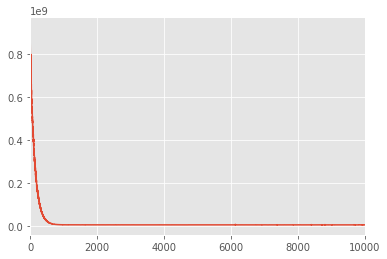

In [52]:
K_list = [450]
K_pval = []
for K in K_list:
    train_data = np.array(x_train, dtype=int)
    D = train_data.shape[1]
    N = train_data.shape[0]

    tf.reset_default_graph()
    sess = tf.InteractiveSession()

    idx_ph = tf.placeholder(tf.int32, M)
    x_ph = tf.placeholder(tf.float32, [M, D])

    U = Gamma(0.1, 0.5, sample_shape=[M,K])
    V = Gamma(0.1, 0.3, sample_shape=[D,K])
    x = Poisson(tf.matmul(U, V, transpose_b=True))

    min_scale = 1e-5

    qV_variables = [tf.Variable(tf.random_uniform([D, K])), \
                    tf.Variable(tf.random_uniform([D, K]))]

    qV = TransformedDistribution(
                distribution=Normal(qV_variables[0],\
                                    tf.maximum(tf.nn.softplus(qV_variables[1]), \
                                               min_scale)),
                bijector=tf.contrib.distributions.bijectors.Exp())


    qU_variables = [tf.Variable(tf.random_uniform([N, K])), \
                    tf.Variable(tf.random_uniform([N, K]))]


    qU = TransformedDistribution(
                distribution=Normal(tf.gather(qU_variables[0], idx_ph),\
                                    tf.maximum(tf.nn.softplus(tf.gather(qU_variables[1], idx_ph)), \
                                               min_scale)),
                bijector=tf.contrib.distributions.bijectors.Exp())


    scale_factor = float(N) / M

    # We apply variational EM with E-step over local variables
    # and M-step to point estimate the global weight matrices.
    inference_e = ed.KLqp({U: qU},
                        data={x: x_ph, V:qV})
    inference_m = ed.KLqp({V:qV},
                       data={x: x_ph, U:qU})

    optimizer_e = tf.train.RMSPropOptimizer(1e-4)
    optimizer_m = tf.train.RMSPropOptimizer(1e-4)

    inference_e.initialize(scale={x: scale_factor, U: scale_factor}, var_list=qU_variables, optimizer="rmsprop")
    inference_m.initialize(scale={x: scale_factor, U: scale_factor}, optimizer="rmsprop")

    tf.global_variables_initializer().run()

    loss = []
    n_epoch = 20
    n_iter_per_epoch = 500
    for epoch in range(n_epoch):
    #     print("Epoch {}".format(epoch))
        nll = 0.0

        pbar = Progbar(n_iter_per_epoch)
        for t in range(n_iter_per_epoch):
            x_batch, idx_batch = next_batch(train_data, M)
    #         x_batch = x_batch.todense()
            pbar.update(t)
            info_dict_e = inference_e.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
            info_dict_m = inference_m.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
            nll += info_dict_e['loss']
    #         print('\n'+str(info_dict_e['loss']))    
            loss.append(info_dict_e['loss'])

    pd.Series(loss).plot()

    V_post = TransformedDistribution(
                distribution=Normal(qV_variables[0],\
                                    tf.maximum(tf.nn.softplus(qV_variables[1]), \
                                               min_scale)),
                bijector=tf.contrib.distributions.bijectors.Exp())
    U_post = TransformedDistribution(
                distribution=Normal(qU_variables[0],\
                                    tf.maximum(tf.nn.softplus(qU_variables[1]), \
                                               min_scale)),
                bijector=tf.contrib.distributions.bijectors.Exp())

    pmf_conf = U_post

    x_post = Poisson(tf.matmul(U_post, V_post, transpose_b=True))

    ### predictive check

    n_rep = 100 # number of replicated datasets we generate
    holdout_gen = np.zeros((n_rep, x_train.shape[0], x_train.shape[1]))
    
    for i in range(n_rep):
        x_generated = x_post.sample().eval()

        # look only at the heldout entries
        holdout_gen[i] = np.multiply(x_generated, holdout_mask)

    n_eval = 10 # we draw samples from the inferred Z and W
    obs_ll = []
    rep_ll = []
    for j in range(n_eval):
        U_sample = U_post.sample().eval()
        V_sample = V_post.sample().eval()

        holdoutmean_sample = np.multiply(U_sample.dot(V_sample.T), holdout_mask)
        obs_ll.append(\
            np.mean(np.ma.masked_invalid(stats.poisson.logpmf(np.array(x_vad, dtype=int), \
                                                              holdoutmean_sample)), axis=0))

        rep_ll.append(\
            np.mean(np.ma.masked_invalid(stats.poisson.logpmf(holdout_gen, \
                                                              holdoutmean_sample)), axis=1))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)

    pvals = np.array([np.mean(rep_ll_per_zi[:,i] < obs_ll_per_zi[i]) for i in range(len(obs_ll_per_zi))])
    holdout_subjects = np.unique(holdout_col)
    overall_pval = np.mean(pvals[holdout_subjects])
    print("Predictive check p-values", overall_pval)
    K_pval.append(overall_pval)

In [53]:
### save result
x_post_np = x_post.mean().eval()
pmf_Z_post_np = pmf_conf.eval()

np.savetxt(os.path.join(DATA_PATH, "x_post_np_PMF_k450.txt"), x_post_np) 

# Deconfounder: DEF

In [55]:
N = x_train.shape[0]  # number of data points
D = x_train.shape[1]  # data dimensionality
min_scale = 1e-5
print (N, D)
train_data = np.array(x_train, dtype=int)



q = 'lognormal'  # choice of q; 'lognormal' or 'gamma'
shape = 0.1  # gamma shape parameter
lr = 1e-3  # learning rate step-size
logdir = '~/log/def/'
logdir = os.path.expanduser(logdir)

tf.reset_default_graph()
sess = tf.InteractiveSession()

# note this x matrix is transpose of the other matrices in PPCA/PMF
x_ph = tf.placeholder(tf.float32, [M, D])
idx_ph = tf.placeholder(tf.int32, M)


# MODEL
Ks = [2, 2]  #
W1 = Gamma(0.1, 0.3, sample_shape=[Ks[1], Ks[0]])
W0 = Gamma(0.1, 0.3, sample_shape=[Ks[0], D])

z2 = Gamma(0.1, 0.1, sample_shape=[M, Ks[1]])
z1 = Gamma(shape, shape / tf.matmul(z2, W1))

x = Poisson(tf.matmul(z1, W0))


# INFERENCE
def pointmass_q(shape):
    min_mean = 1e-3
    mean_init = tf.random_normal(shape)
    rv = PointMass(tf.maximum(tf.nn.softplus(tf.Variable(mean_init)), min_mean))
    return rv


def gamma_q(shape):
    # Parameterize Gamma q's via shape and scale, with softplus unconstraints.
    min_shape = 1e-3
    min_scale = 1e-5
    shape_init = 0.5 + 0.1 * tf.random_normal(shape)
    scale_init = 0.1 * tf.random_normal(shape)
    rv = Gamma(tf.maximum(tf.nn.softplus(tf.Variable(shape_init)),
                        min_shape),
             tf.maximum(1.0 / tf.nn.softplus(tf.Variable(scale_init)),
                        1.0 / min_scale))
    return rv


def lognormal_q(shape):
    min_scale = 1e-5
    loc_init = tf.random_normal(shape)
    scale_init = 0.1 * tf.random_normal(shape)
    rv = TransformedDistribution(
      distribution=Normal(
          tf.Variable(loc_init),
          tf.maximum(tf.nn.softplus(tf.Variable(scale_init)), min_scale)),
      bijector=tf.contrib.distributions.bijectors.Exp())
    return rv



qW1 = pointmass_q(W1.shape)
qW0 = pointmass_q(W0.shape)


qz2 = lognormal_q(z2.shape)
qz1 = lognormal_q(z1.shape)

qz2_variables = [tf.Variable(tf.random_uniform([N, Ks[1]])), \
                tf.Variable(tf.random_uniform([N, Ks[1]]))]


qz2 = TransformedDistribution(
            distribution=Normal(tf.gather(qz2_variables[0], idx_ph),\
                                tf.maximum(tf.nn.softplus(tf.gather(qz2_variables[1], idx_ph)), \
                                           min_scale)),
            bijector=tf.contrib.distributions.bijectors.Exp())

# We apply variational EM with E-step over local variables
# and M-step to point estimate the global weight matrices.
inference_e = ed.KLqp({z1: qz1, z2: qz2},
                      data={x: x_ph, W0: qW0, W1: qW1})
inference_m = ed.MAP({W0: qW0, W1: qW1},
                     data={x: x_ph, z1: qz1, z2: qz2})

scale_factor = float(N) / M


optimizer_e = tf.train.RMSPropOptimizer(lr)
optimizer_m = tf.train.RMSPropOptimizer(lr)
timestamp = datetime.strftime(datetime.utcnow(), "%Y%m%d_%H%M%S")
logdir += timestamp + '_' + '_'.join([str(ks) for ks in Ks]) + \
    '_q_' + str(q) + '_lr_' + str(lr)
kwargs = {'optimizer': optimizer_e,
          'n_print': 100,
          'logdir': logdir,
          'log_timestamp': False, 
          'scale': {x: scale_factor, z2: scale_factor}}

if q == 'gamma':
    kwargs['n_samples'] = 30
inference_e.initialize(**kwargs)
inference_m.initialize(optimizer=optimizer_m, \
                       scale = {x: scale_factor, z2: scale_factor})

sess = ed.get_session()
tf.global_variables_initializer().run()


loss = []
n_epoch = 20
n_iter_per_epoch = 1000
for epoch in range(n_epoch):
    print("Epoch {}".format(epoch))
    nll = 0.0

    pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        x_batch, idx_batch = next_batch(train_data, M)
        # this extra step is because the x matrix is 
        # transpose of the other matrices in PPCA/PMF
#         x_batch = x_batch.T 
        pbar.update(t)
        info_dict_e = inference_e.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
        info_dict_m = inference_m.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
        nll += info_dict_e['loss']
        loss.append(info_dict_e['loss'])

    # Compute perplexity averaged over a number of training iterations.
    # The model's negative log-likelihood of data is upper bounded by
    # the variational objective.
    nll = nll / n_iter_per_epoch
    perplexity = np.exp(nll / np.sum(x_train))
    print("Negative log-likelihood <= {:0.3f}".format(nll))
    print("Perplexity <= {:0.3f}".format(perplexity))

z2_post = TransformedDistribution(
            distribution=Normal(qz2_variables[0],\
                                tf.maximum(tf.nn.softplus(qz2_variables[1]), \
                                           min_scale)),
            bijector=tf.contrib.distributions.bijectors.Exp())

z1_post = Gamma(shape, shape / tf.matmul(z2_post, qW1))

x_post = Poisson(tf.matmul(z1_post, qW0))

5000 50
Epoch 0
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s
Negative log-likelihood <= 391532.458
Perplexity <= 175.706
Epoch 1
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s
Negative log-likelihood <= 207840.734
Perplexity <= 15.546
Epoch 2
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s
Negative log-likelihood <= 185318.102
Perplexity <= 11.548
Epoch 3
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s
Negative log-likelihood <= 181456.758
Perplexity <= 10.974
Epoch 4
1000/1000 [100%] ██████████████████████████████ Elapsed: 4s
Negative log-likelihood <= 180486.477
Perplexity <= 10.834
Epoch 5
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s
Negative log-likelihood <= 179707.286
Perplexity <= 10.723
Epoch 6
1000/1000 [100%] ██████████████████████████████ Elapsed: 4s
Negative log-likelihood <= 179957.161
Perplexity <= 10.759
Epoch 7
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s
Negative log-likelihood <= 179873.

In [56]:
n_rep = 100 # number of replicated datasets we generate
holdout_gen = np.zeros((n_rep, x_train.shape[0], x_train.shape[1]))

for i in range(n_rep):
    x_generated = x_post.sample().eval()
    
    # look only at the heldout entries
    holdout_gen[i] = np.multiply(x_generated, holdout_mask)

n_eval = 10 # we draw samples from the inferred Z and W
obs_ll = []
rep_ll = []
pbar = Progbar(n_eval)
for j in range(1, n_eval+1):
    z1_sample = z1_post.sample().eval()
    W0_sample = qW0.sample().eval()
    
    holdoutmean_sample = np.multiply(z1_sample.dot(W0_sample), holdout_mask)
    obs_ll.append(np.mean(np.ma.masked_invalid(stats.poisson.logpmf(np.array(x_vad, dtype=int), holdoutmean_sample)), axis=0))

    rep_ll.append(np.mean(np.ma.masked_invalid(stats.poisson.logpmf(holdout_gen, holdoutmean_sample)), axis=1))
    pbar.update(j)
    
obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)

pvals = np.array([np.mean(rep_ll_per_zi[:,i] < obs_ll_per_zi[i]) for i in range(len(obs_ll_per_zi))])
holdout_subjects = np.unique(holdout_col)
overall_pval = np.mean(pvals[holdout_subjects])
print("Predictive check p-values", overall_pval)

10/10 [100%] ██████████████████████████████ Elapsed: 27s
Predictive check p-values 0.614


In [57]:
# reconstruct causes
x_post_np = x_post.mean().eval()
# drug latent variables
def_Z_post_np = qW0.mean().eval()
# patient latent variables
z1_post_np = z1_post.mean().eval()
### save result
np.savetxt(os.path.join(DATA_PATH, "x_post_np_DEF_2_2.txt"), x_post_np) 

# Outcome model in R...